Text(0.5, 1.0, 'Rice Production graph from the UChicago paper')

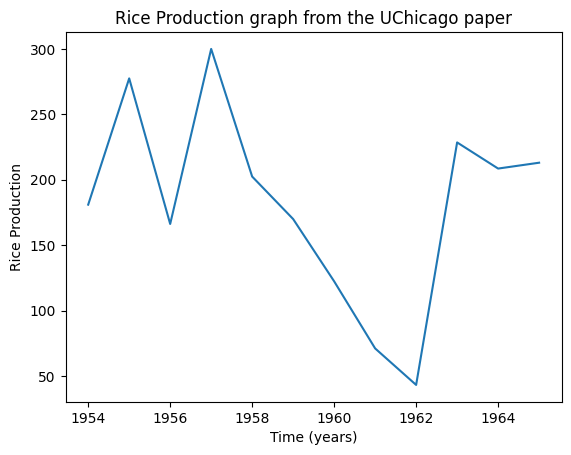

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

years = [1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965]
rice_production = np.array([-39.69, -7.51, -44.61, 0, -32.53, -43.36, -59.23, -76.33, -85.63, -23.83, -30.49, -29.0])
# Transformed data for the Grain component (G_data)
G_data = (rice_production + 100.0) * 3
t_data = np.arange(len(G_data)) # Time points: 0, 1, 2, ..., 11

plt.plot(years, G_data)
plt.xlabel('Time (years)')
plt.ylabel('Rice Production')
plt.title('Rice Production graph from the UChicago paper')

In [2]:
def system(t, y, Eh, Ef, *params): 
    """
    ODE System: Sparrows (S), Locusts (L), Grain (G)
    13 parameters: a1, a2, a3, a4, b1, b2, b3, r, b4, b5, c1, c2, c3
    2 fixed external efforts: Eh (Sparrow Hunting), Ef (Farming Effort)
    
    a1 is the sparrow growth rate per locust
    a2 is the sparrow growth rate per grain
    a3 is the sparrow death rate
    
    used the sigmoid function for the locust growth function
    https://www.desmos.com/calculator/uqoxscmzf1
    wanted a continuous version of h(L) = (L < b_3) ? b1 : b2
    b1 is the solitarious growth rate
    b2 is the gregarious growth rate
    b3 is the turn on threshold
    r is how sharp the "turn on" is
    """
    S, L, G = y
    a1, a2, a3, a4, b1, b2, b3, r, b4, b5, c1, c2, c3 = params
    
    locust_growth = ((b2 - b1) / (1 + np.e**(r * (b3 - L)))) + b1

    dS = (a1 * S * L) + (a2 * S * G) - (a3 * S) - (a4 * Eh * S)
    dL = (locust_growth * L) - (b4 * L) - (b5 * S * L) 
    dG = (c1 * Ef) - (c2 * G * S) - (c3 * G * L)

    return [dS, dL, dG]

S0 = 10
L0 = 100
G0 = G_data[0]
y0 = [S0, L0, G0]

params = [1e-2,  1e-7, 1.2, 10.0, 0.1, 1.7, .5, .5, 0.1, 0.001,  10.0, 1, 1]
#         a1,       a2, a3, a4,   b1, b2, b3,   r, b4, b5, c1, c2, c3

t_span = (0, 12)
t_eval = np.linspace(0, 12, 100)


def run_simulation(Eh=0.0, Ef=0.0):
    """Simulate and optionally plot the system for given hunting/farming efforts."""
    sol = solve_ivp(system, t_span, y0, t_eval=t_eval, args=(Eh, Ef, *params))

    plt.figure(figsize=(8,5))
    plt.plot(sol.t, sol.y[0], label=f'Sparrows')
    plt.plot(sol.t, sol.y[1], label=f'Locusts')
    plt.plot(sol.t, sol.y[2], label=f'Grain')
    plt.xlabel('Time (years)')
    plt.ylabel('Individuals / Index')
    plt.title(f'Simulation: Eh={Eh}, Ef={Ef}')
    plt.legend()
    # plt.grid(True)
    plt.show()

    print("Year |   S (sparrows)   |   L (locusts)   |   G (grain)")
    print("-" * 52)
    for year, S, L, G in zip(years, *sol.y):
        print(f"{year:<5} | {S:>15.3f} | {L:>15.3f} | {G:>15.3f}")

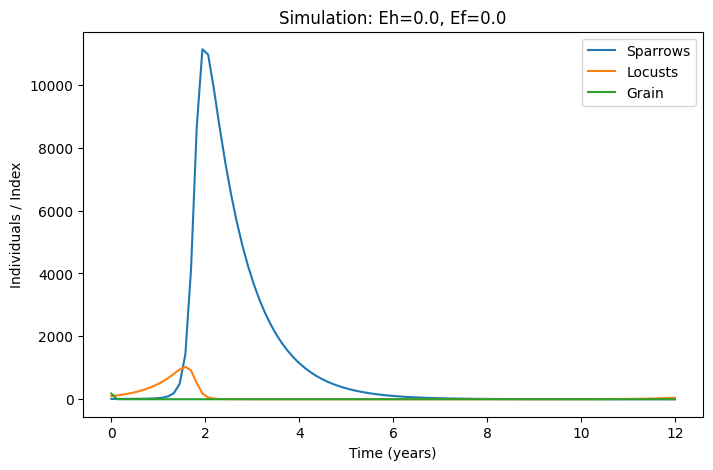

Year |   S (sparrows)   |   L (locusts)   |   G (grain)
----------------------------------------------------
1954  |          10.000 |         100.000 |         180.930
1955  |           9.883 |         121.256 |           0.000
1956  |          10.049 |         147.031 |          -0.000
1957  |          10.576 |         178.276 |          -0.000
1958  |          11.605 |         216.142 |           0.000
1959  |          13.395 |         262.007 |          -0.000
1960  |          16.437 |         317.513 |          -0.000
1961  |          21.722 |         384.589 |           0.000
1962  |          31.392 |         465.428 |          -0.000
1963  |          50.513 |         562.320 |           0.000
1964  |          92.393 |         677.020 |           0.000
1965  |         196.266 |         808.473 |          -0.000


In [3]:
run_simulation(Eh=0.0, Ef=0.0)

In [4]:
# Initial Conditions (S0, L0, G0)
S0 = 10.0
L0 = 100.0
G0 = G_data[0] # Start the simulation at the first observed grain value
y0 = [S0, L0, G0]

# Initial Guess for Parameters
#    a1,     a2, a3, a4,   b1, b2, b3,   r, b4, b5, c1, c2, c3
initial_params = np.array([1e-2, 1e-7, 0.2, 0.0, 0.1, 1.7, 0.5, 0.5, 0.1, 0.001, 10.0, 1, 1])

Eh_fit = 0.0
Ef_fit = 0.0 

# Lb: Lower Bounds, Ub: Upper Bounds
Lb = [0.0] * 13
Ub = [10.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 50.0, 10.0, 10.0]
bounds = (Lb, Ub)

def residuals(params, t_data, G_data, y0, Eh, Ef):
    """Calculates the difference between the simulated G and the observed G_data."""
    t_span = (t_data[0], t_data[-1])
    
    sol = solve_ivp(system, t_span, y0, t_eval=t_data, args=(Eh, Ef, *params))

    simulated_G = sol.y[2]

    return simulated_G - G_data

# Perform the optimization
print("Starting parameter fitting...")
fit_result = least_squares(
    residuals, 
    initial_params, 
    args=(t_data, G_data, y0, Eh_fit, Ef_fit), 
    bounds=bounds,
    verbose=2 
)

fitted_params = fit_result.x
print(fitted_params)
print(f"Final Cost (Sum of Squared Residuals): {fit_result.cost:.2f}")

Starting parameter fitting...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1369e+05                                    1.57e+05    
       1              3         2.1369e+05      2.90e-04       2.17e-01       1.02e-01    
       2              4         2.1369e+05      1.16e-05       3.86e-02       2.58e-01    
       3              6         2.1369e+05      1.05e-04       2.04e-03       3.32e+00    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 2.1369e+05, final cost 2.1369e+05, first-order optimality 3.32e+00.
[9.80586708e-03 9.95020064e-08 1.98080411e-01 1.00000283e-10
 9.99940854e-02 1.71276368e+00 4.99931677e-01 5.00039221e-01
 9.97659202e-02 2.12302903e-01 1.00000000e+01 1.01829661e+00
 1.03327666e+00]
Final Cost (Sum of Squared Residuals): 213687.95


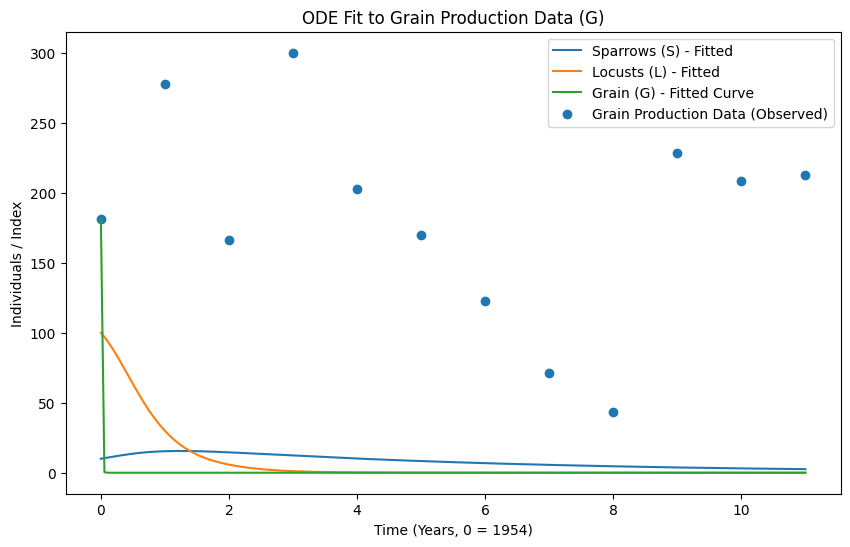


--- Fitted Dynamics ---
Year | Data G | Model G | S (Sparrows) | L (Locusts)
----------------------------------------------------
0    |  180.93 |  180.93 |        10.00 |     100.00
1    |  277.47 |    0.00 |        15.38 |      29.91
2    |  166.17 |    0.00 |        14.56 |       5.78
3    |  300.00 |    0.00 |        12.28 |       1.11
4    |  202.41 |    0.00 |        10.13 |       0.23
5    |  169.92 |   -0.00 |         8.32 |       0.07
6    |  122.31 |    0.00 |         6.83 |       0.03
7    |   71.01 |    0.00 |         5.60 |       0.02
8    |   43.11 |   -0.00 |         4.59 |       0.01
9    |  228.51 |    0.00 |         3.77 |       0.01
10   |  208.53 |    0.00 |         3.09 |       0.01
11   |  213.00 |    0.00 |         2.54 |       0.01


In [5]:
def plot_fit(fitted_params, t_data, G_data, y0, Eh, Ef):
    # Full time span for a smooth curve
    t_eval_full = np.linspace(t_data[0], t_data[-1], 200) 
    
    sol_fit = solve_ivp(system, (t_data[0], t_data[-1]), y0, t_eval=t_eval_full, args=(Eh, Ef, *fitted_params))

    plt.figure(figsize=(10, 6))
    
    # Plotting the three components
    plt.plot(sol_fit.t, sol_fit.y[0], label='Sparrows (S) - Fitted')
    plt.plot(sol_fit.t, sol_fit.y[1], label='Locusts (L) - Fitted')
    plt.plot(sol_fit.t, sol_fit.y[2], label='Grain (G) - Fitted Curve')
    
    # Plotting the original data points
    plt.scatter(t_data, G_data, label='Grain Production Data (Observed)')
    
    plt.xlabel('Time (Years, 0 = 1954)')
    plt.ylabel('Individuals / Index')
    plt.title('ODE Fit to Grain Production Data (G)')
    plt.legend(loc='upper right')
    plt.show()

# Run and plot the final fitted model
plot_fit(fitted_params, t_data, G_data, y0, Eh_fit, Ef_fit)

print("\n--- Fitted Dynamics ---")
# Evaluate solution at original data points for comparison
sol_comp = solve_ivp(system, (t_data[0], t_data[-1]), y0, t_eval=t_data, args=(Eh_fit, Ef_fit, *fitted_params))

print("Year | Data G | Model G | S (Sparrows) | L (Locusts)")
print("-" * 52)
for i in range(len(t_data)):
    year_idx = t_data[i]
    data_g = G_data[i]
    model_g = sol_comp.y[2][i]
    S_val = sol_comp.y[0][i]
    L_val = sol_comp.y[1][i]
    print(f"{int(year_idx):<4} | {data_g:7.2f} | {model_g:7.2f} | {S_val:12.2f} | {L_val:10.2f}")